In [1]:
from randomDistricts import Hierarchy_2D
from gerrychain.random import random
from gerrychain import (Graph, Partition, MarkovChain, tree,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from treelib import Node, Tree
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
with open("data/dallas_hierarcy.p", "rb") as fin:
    h = pickle.load(fin)

In [9]:
h.gdf.TRACTCE10 = h.gdf.TRACTCE10.apply(lambda x: "48113" + x )

In [10]:
tracts = h.gdf[["TOTPOP10", "VAP10", "tract", "geometry"]].dissolve(by="tract", aggfunc="sum")

In [11]:
tracts = tracts.reset_index()

In [13]:
tracts.to_file("data/dallas_county_tracts.shp")

## Set Up Params and Functions

In [3]:
num_dists = 4
pop_col = "TOTPOP10"
total_pop = h.gdf.TOTPOP10.sum()
ideal_pop = total_pop / num_dists
eps = 0.02

In [37]:
def sample_recom_partitions(init_part, ideal_pop, pop_col, eps, tot_steps=1000, compactness=False):
    proposal = partial(recom,
                       pop_col=pop_col,
                       pop_target=ideal_pop,
                       epsilon=eps,
                       node_repeats=1)
    pop_constraint = constraints.within_percent_of_ideal_population(init_part, eps)
    compactness_bound = constraints.UpperBound(
        lambda p: len(p["cut_edges"]),
        2*len(init_part["cut_edges"])
    )

    chain = MarkovChain(
        proposal=proposal,
        constraints=[pop_constraint, compactness_bound] if compactness else [pop_constraint],
        accept=accept.always_accept,
        initial_state=init_part,
        total_steps=tot_steps
    )
    
    parts = np.zeros(int(tot_steps/10), dtype="object")
    for i, p in tqdm(enumerate(chain)):
        if i % 10 == 9:
            parts[int(i / 10)] = p
    print()
    
    return parts

In [21]:
def recom_partitions_to_districts(parts, block_graph, pop_col, tracts=False):
    
    if not tracts: assert(parts[0].graph == block_graph)
    
    ds = set()
    for p in parts:
        if tracts:
            ds |= set(map(lambda dist: frozenset(map(lambda n: "48113" + p.graph.nodes[n]["tract"], dist)), 
                          p.parts.values()))
        else:
            ds |= set(p.parts.values())

    
    ## Covert to parts
    districts = {}
    d_parts = np.zeros(len(ds), dtype="object")
    d_dicts = np.zeros(len(ds), dtype="object")
    for i, d in tqdm(enumerate(ds)):
        if tracts:
            d_parts[i] = {n: int(block_graph.nodes[n]["geoid"][:-4] in d) for n in block_graph.nodes}
            d_dicts[i] = {block_graph.nodes[n]["geoid"]: int(block_graph.nodes[n]["geoid"][:-4] in d) for n in block_graph.nodes}
        else:
            d_parts[i] = {n: int(n in d) for n in block_graph.nodes}
            d_dicts[i] = {block_graph.nodes[n]["geoid"]: int(n in d) for n in block_graph.nodes}
        
    districts["dicts"] = d_dicts
    districts["parts"] = d_parts
    return districts

## Tract Recom Districts

In [30]:
tract_g = Graph.from_file("data/dallas_county_tracts.shp")

In [31]:
cdict = tree.recursive_tree_part(tract_g, range(num_dists), ideal_pop, pop_col, eps, node_repeats=1)

In [32]:
init_part_tracts = Partition(tract_g, cdict, updaters={"cut_edges": cut_edges, 
                                                       "population": Tally(pop_col, alias="population")})

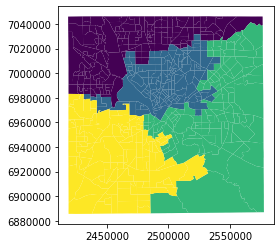

In [33]:
init_part_tracts.plot()

In [34]:
init_part_tracts['population']

{0: 586123, 1: 599692, 2: 598774, 3: 583550}

In [38]:
tract_parts = sample_recom_partitions(init_part_tracts, ideal_pop, pop_col, eps, tot_steps=1000)

1000it [01:21, 12.23it/s]

In [39]:
tract_parts_comp = sample_recom_partitions(init_part_tracts, ideal_pop, pop_col, eps, tot_steps=1000, compactness=True)

1000it [01:27, 11.41it/s]

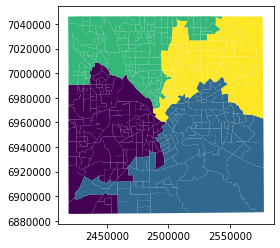

In [46]:
tract_parts_comp[20].plot()

In [207]:
dists_comp = recom_partitions_to_districts(tract_parts_comp, h.graph, pop_col, tracts=True)

399it [01:04,  6.18it/s]


In [223]:
np.save("sample_districts/100_recom_tract_parts_comp.npy", [dists_comp], allow_pickle=True)

In [224]:
tract_dists = np.load("sample_districts/100_recom_tract_parts_comp.npy", allow_pickle=True)[0]

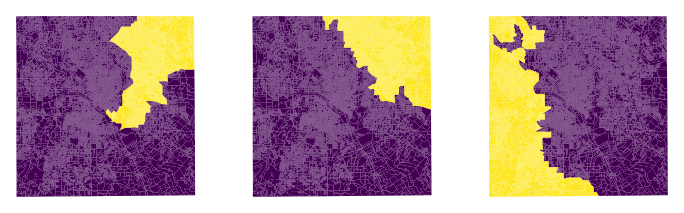

In [225]:
num_dists_to_plot = 3
fig, axs = plt.subplots(1, num_dists_to_plot, figsize=(12,4))
ps = np.random.choice(tract_dists["parts"], size=num_dists_to_plot, replace=False)
for i in range(num_dists_to_plot):
    Partition(h.graph, ps[i]).plot(ax=axs[i])
    axs[i].set_axis_off()
plt.show()

## Block Recom Districts

In [4]:
block_g = h.graph

In [219]:
cdict = tree.recursive_tree_part(block_g, range(num_dists), ideal_pop, pop_col, eps, node_repeats=1)

In [220]:
init_part_blocks = Partition(block_g, cdict, updaters={"cut_edges": cut_edges, 
                                                       "population": Tally(pop_col, alias="population")})

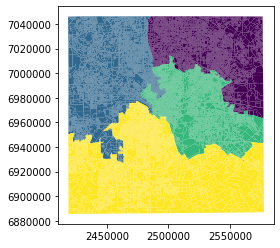

In [221]:
init_part_blocks.plot()

In [222]:
init_part_blocks['population']

{0: 594447, 1: 580460, 2: 598615, 3: 594617}

In [226]:
block_parts = sample_recom_partitions(init_part_blocks, ideal_pop, pop_col, eps, tot_steps=1000, compactness=True)

1000it [2:23:52,  8.63s/it]

In [227]:
dists = recom_partitions_to_districts(block_parts, h.graph, pop_col, tracts=False)

398it [00:29, 13.28it/s]


In [231]:
np.save("sample_districts/100_recom_block_parts_comp.npy", [dists], allow_pickle=True)

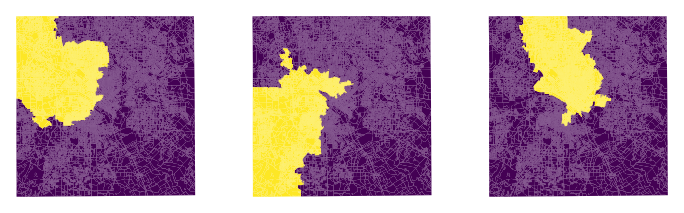

In [229]:
num_dists_to_plot = 3
fig, axs = plt.subplots(1,num_dists_to_plot, figsize=(12,4))
ps = np.random.choice(dists["parts"], size=num_dists_to_plot, replace=False)
for i in range(num_dists_to_plot):
    Partition(h.graph, ps[i]).plot(ax=axs[i])
    axs[i].set_axis_off()
plt.show()

## Square Districts -- Bounding Box Flood Fill on Blocks

In [5]:
def bounding_box_iid(G, ideal_pop, pop_map, ep, bounding_box_dict):

    district_nodes = []
    processed_nodes = set()
    seed = random.choice(list(G.nodes()))
    district_nodes.append(seed)

    local_frontier = set(G.neighbors(seed))
    processed_nodes.add(seed)
    cur_dist_pop = pop_map[seed]
    bounding_box = bounding_box_dict[seed]
    while cur_dist_pop < ideal_pop:


        if len(local_frontier) == 0 and cur_dist_pop < (1-ep)*ideal_pop:
            return False, district_nodes
        if len(local_frontier) == 0 and cur_dist_pop >= (1-ep)*ideal_pop:
            return True, district_nodes

        bounded_frontier = []
        box_x_min = bounding_box[0]
        box_x_max = bounding_box[1]
        box_y_min = bounding_box[2]
        box_y_max = bounding_box[3]

        for v in local_frontier:
            if box_x_min <= bounding_box_dict[v][0] and box_x_max >= bounding_box_dict[v][1] and box_y_min <= bounding_box_dict[v][2] and box_y_max >= bounding_box_dict[v][3]:
                bounded_frontier.append(v)

        if len(bounded_frontier) > 0:
            spread = random.choice(bounded_frontier)
        else:
            spread = random.choice(list(local_frontier))

        if cur_dist_pop + pop_map[spread] > (1+ep)*ideal_pop:
            local_frontier.remove(spread)
        else:
            bounding_box = [min(box_x_min,bounding_box_dict[spread][0]),
                            max(box_x_max,bounding_box_dict[spread][1]),
                            min(box_y_min,bounding_box_dict[spread][2]),
                            max(box_y_max,bounding_box_dict[spread][3])]
            processed_nodes.add(spread)
            district_nodes.append(spread)
            cur_dist_pop += pop_map[spread]

            local_frontier = local_frontier.union(set(G.neighbors(spread))).difference(processed_nodes)
    return True, district_nodes

In [11]:
def sample_bounding_box_flood_fill(G, num_districts, bounding_box_ep=0.2):
    pop_map = {v:G.nodes[v]['TOTPOP10'] for v in G.nodes()}
    pos_map = {v:(float(G.nodes[v]['INTPTLON10']),float(G.nodes[v]['INTPTLAT10'])) for v in G.nodes()}
    maxlon = max(pos_map[v][0] for v in G.nodes())
    minlon = min(pos_map[v][0] for v in G.nodes())
    lon_diff = maxlon-minlon
    maxlat = max(pos_map[v][1] for v in G.nodes())
    minlat = min(pos_map[v][1] for v in G.nodes())
    lat_diff = maxlat-minlat
    bounding_box_dict = {v:[pos_map[v][0] + bounding_box_ep*lon_diff,
                            pos_map[v][0]+ bounding_box_ep*lon_diff, 
                            pos_map[v][1]+ bounding_box_ep*lat_diff,
                            pos_map[v][1]+ bounding_box_ep*lat_diff] for v in G.nodes()}  
    
    districts = {}
    d_parts = np.zeros(num_districts, dtype="object")
    d_dicts = np.zeros(num_districts, dtype="object")
    for i in tqdm(range(num_districts)):
        success, plan = bounding_box_iid(G, ideal_pop, pop_map, eps, bounding_box_dict)
        if success:
            d_parts[i] = {v: int(v in plan) for v in G.nodes()}
            d_dicts[i] = {G.nodes[v]["geoid"]: int(v in plan) for v in G.nodes()}
        else:
            print("failure")
    districts["dicts"] = d_dicts
    districts["parts"] = d_parts
    
    return districts

In [16]:
block_bb_dists = sample_bounding_box_flood_fill(block_g, 400)

100%|██████████| 400/400 [17:44:11<00:00, 159.63s/it]    


In [18]:
np.save("sample_districts/400_squre_block_dists.npy", [block_bb_dists], allow_pickle=True)

In [14]:
block_bb_parts.keys()

dict_keys(['dicts', 'parts'])

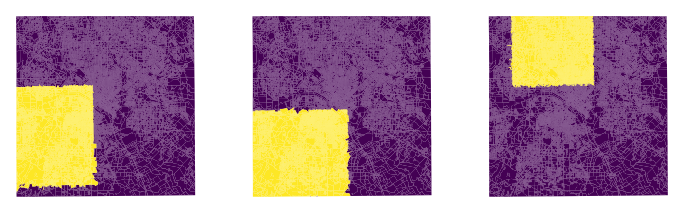

In [19]:
num_dists_to_plot = 3
fig, axs = plt.subplots(1,num_dists_to_plot, figsize=(12,4))
ps = np.random.choice(block_bb_dists["parts"], size=num_dists_to_plot, replace=False)
for i in range(num_dists_to_plot):
    Partition(h.graph, ps[i]).plot(ax=axs[i])
    axs[i].set_axis_off()
plt.show()

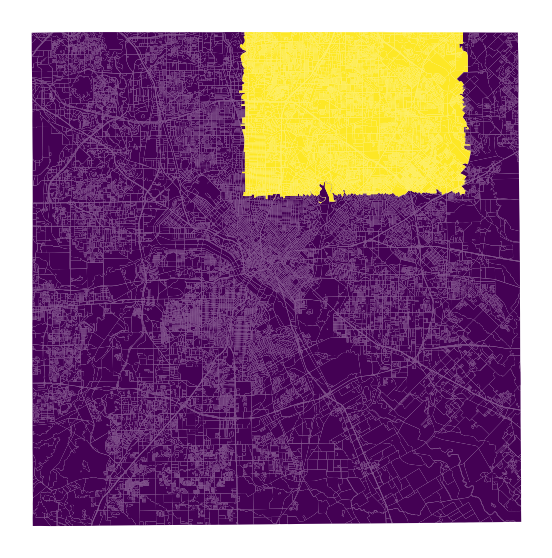

In [11]:
p = Partition(G, d_parts[2], updaters={"cut_edges": cut_edges, 
                                    "population": Tally("TOTPOP10")})
p.plot(figsize=(10,10))
plt.axis('off')
plt.show()

## Block Flood Fill

In [233]:
p, d = h.build_district(4)

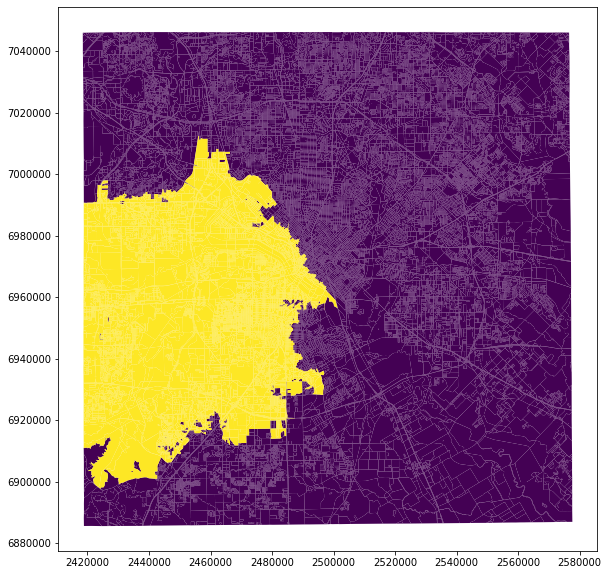

In [235]:
p.plot(figsize=(10,10))